In [174]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema


from fink_utils.sso import spins as finkus
import ssptools

# Get ZTF fit

In [14]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '/data/fink/tutorials/sso/spins/'
data_fink = './'

# To choose the definition of sets
# gold_silver_choice = 'julien'
gold_silver_choice = 'benoit'

In [305]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])

# From apparent magnitude to unit distance
def dist_reduction( d_obs, d_sun):
    return 5*np.log10( d_obs * d_sun )

V_minus_g = -0.32
V_minus_r = 0.36       


In [16]:
data = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_allsolutions.parquet')

# Check results for individual SSOs

In [325]:
target = '53951'

In [326]:
# Get ZTF observations
r = requests.post(
  'https://fink-portal.org/api/v1/sso',
  json={
    'n_or_d': target,
    'withEphem': True,
    'output-format': 'json'
  }
)

# Format output in a DataFrame
ztf = pd.read_json(io.BytesIO(r.content))
len(ztf)

192

In [327]:
# Compute Ephemerides
jd_min = ztf['Date'].min()
jd_max = ztf['Date'].max()
step = 5
nbd = (jd_max-jd_min) / step

eph = ssptools.ephemcc( target, ep=jd_min, nbd=nbd, step=f'{step}d')

# obs = ssptools.ephemcc( target, ep=ztf.Date)

HG       : 14.59  0.08
HG1G2    : 14.07  0.04  0.25
HG1G2spin: 14.61  0.58  0.32
HG21G1  g: 14.84  0.60  0.34   154.1  48.6   0.48
HG21G1  r: 14.29  0.52  0.37   154.1  48.6   0.48


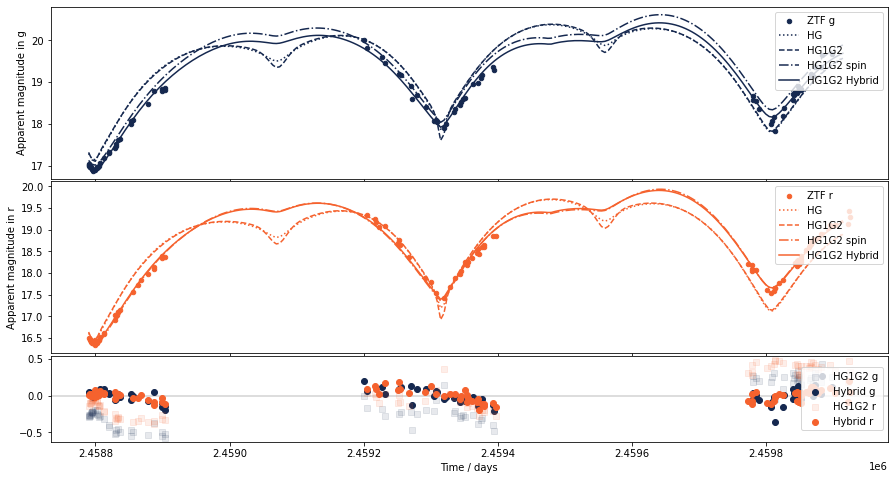

In [328]:
# Mag vs Time
fig, ax = plt.subplots(3, 1, figsize=(15,8), 
                       sharex=True, 
                       gridspec_kw={
                           'hspace':0.02, 
                           'height_ratios': [2,2,1]
                       })
# ZTF Colors and Colors
colors = ['#15284F', '#F5622E']

show_HG = True
show_HG1G2 = True
show_HG1G2sp = True
show_HG1G2hyb = True

res_HG = False
res_HG1G2 = True
res_HG1G2sp = False
res_HG1G2hyb = True

for fi, filt in enumerate(['g','r']):

    # --------------------------------------------------------------------------------
    # Plot ZTF observations
    cond = ztf['i:fid']==fi+1
    if filt=='g':
        color_corr = V_minus_g
    else:
        color_corr = V_minus_r
    
    ax[fi].scatter( ztf.loc[cond,'Date'], ztf.loc[cond,'i:magpsf'],
                    s=20, marker='o', 
                    color=colors[fi], 
                    label=f'ZTF {filt}' )
    
    # --------------------------------------------------------------------------------
    # HG model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG_H'].values[0]
    G = data.loc[data.ssnamenr==target, 'HG_G'].values[0]
    if fi==0: print(f'HG       : {H:5.2f}  {G:4.2f}')
    
    # Linear Plot 
    if show_HG:
        pred_mag = finkus.func_hg(np.radians(eph['Phase']), H, G) \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] ) \
                 - color_corr
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dotted', label=f'HG' )

    # Plot residuals
    if res_HG:
        phase = ztf['Phase']
        pred_mag = finkus.func_hg(np.radians(phase), H, G) \
                 - color_corr
        ax[2].scatter( ztf.loc[:,'Date'],
                   ztf.loc[:,'i:magpsf'] \
                    - dist_reduction( ztf.loc[:,'Dobs'], ztf.loc[:,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG' )
        
    # --------------------------------------------------------------------------------
    # HG1G2 model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG1G2_H'].values[0]
    G1 = data.loc[data.ssnamenr==target, 'HG1G2_G1'].values[0]
    G2 = data.loc[data.ssnamenr==target, 'HG1G2_G2'].values[0]
    if fi==0: print(f'HG1G2    : {H:5.2f}  {G1:4.2f}  {G2:4.2f}')
    
    # Linear Plot 
    if show_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(eph['Phase']), H, G1, G2) \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] ) \
                 - color_corr
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dashed', label=f'HG1G2' )
    
    # Plot Residuals
    if res_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(ztf.loc[cond,'Phase']), H, G1, G2) - color_corr
        ax[2].scatter( ztf.loc[cond,'Date'],
                   ztf.loc[cond,'i:magpsf'] \
                    - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2 {filt}' )

    # --------------------------------------------------------------------------------
    # HG1G2spin model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG1G2sp_H'].values[0]
    G1 = data.loc[data.ssnamenr==target, 'HG1G2sp_G1'].values[0]
    G2 = data.loc[data.ssnamenr==target, 'HG1G2sp_G2'].values[0]
    ra0 = data.loc[data.ssnamenr==target, 'HG1G2sp_RA0'].values[0]
    dec0 = data.loc[data.ssnamenr==target, 'HG1G2sp_DEC0'].values[0]
    R = data.loc[data.ssnamenr==target, 'HG1G2hyb_R'].values[0]
    if fi==0: print(f'HG1G2spin: {H:5.2f}  {G1:4.2f}  {G2:4.2f}')

    # Plot 
    if show_HG1G2sp:
        radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(eph.Phase),
                                np.radians(radec.ra.deg),
                                np.radians(radec.dec.deg))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] ) \
                 - color_corr
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dashdot', label=f'HG1G2 spin' )

    # Plot residuals
    if res_HG1G2sp:
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(ztf.loc[cond,'Phase']),
                                np.radians(ztf.loc[cond,'RA']),
                                np.radians(ztf.loc[cond,'Dec']))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
        ax[2].scatter( ztf.loc[cond,'Date'], 
                   ztf.loc[cond,'i:magpsf'] \
                    - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] )\
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2sp' )  
        
        
    # --------------------------------------------------------------------------------
    # Hybrid model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, f'HG1G2hyb_H_{filt}'].values[0]
    G1 = data.loc[data.ssnamenr==target, f'HG1G2hyb_G1_{filt}'].values[0]
    G2 = data.loc[data.ssnamenr==target, f'HG1G2hyb_G2_{filt}'].values[0]
    ra0 = data.loc[data.ssnamenr==target, 'HG1G2hyb_RA0'].values[0]
    dec0 = data.loc[data.ssnamenr==target, 'HG1G2hyb_DEC0'].values[0]
    R = data.loc[data.ssnamenr==target, 'HG1G2hyb_R'].values[0]
    print(f'HG21G1  {filt}: {H:5.2f}  {G1:4.2f}  {G2:4.2f}   {ra0:4.1f}  {dec0:4.1f}   {R:4.2f}')

    # Plot
    if show_HG1G2hyb:
        radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(eph.Phase),
                                np.radians(radec.ra.deg),
                                np.radians(radec.dec.deg))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0))  \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] ) 
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], label=f'HG1G2 Hybrid' )

    # Plot Residuals
    if res_HG1G2hyb:
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(ztf.loc[cond,'Phase']),
                                np.radians(ztf.loc[cond,'RA']),
                                np.radians(ztf.loc[cond,'Dec']))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[2].scatter( ztf.loc[cond,'Date'], 
                       ztf.loc[cond,'i:magpsf'] \
                        - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                        - pred_mag, 
                   color=colors[fi], label=f'Hybrid {filt}' )
    
    
    ax[fi].set_ylabel(f'Apparent magnitude in {filt}')
    ax[fi].legend(loc='upper right')
    

# Residuals
ax[2].axhline(0, color='lightgray', zorder=-100)
ax[2].legend(loc='center right')
    
    
# Axes
ax[2].set_xlabel('Time / days')

fig.savefig(f'{data_fink}/gfx_obs/{target}-time.png', facecolor='white')

HG       : 14.59  0.08
HG1G2    : 14.07  0.04  0.25
HG1G2spin: 14.61  0.58  0.32
HG21G1  g: 14.84  0.60  0.34   154.1  48.6   0.48
HG21G1  r: 14.29  0.52  0.37   154.1  48.6   0.48


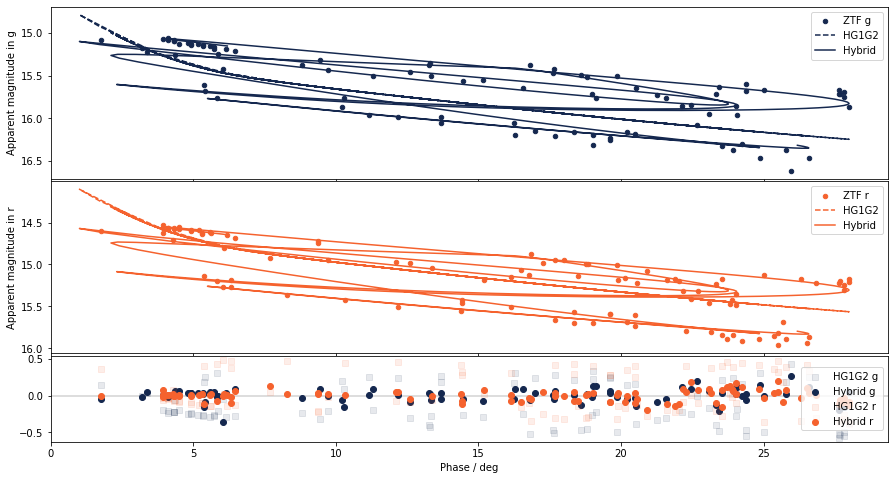

In [329]:
# Mag vs Phase
fig, ax = plt.subplots(3, 1, figsize=(15,8), 
                       sharex=True, 
                       gridspec_kw={
                           'hspace':0.02, 
                           'height_ratios': [2,2,1]
                       })

# ZTF Colors and Colors
colors = ['#15284F', '#F5622E']
       

show_HG = False
show_HG1G2 = True
show_HG1G2sp = False
show_HG1G2hyb = True

res_HG = False
res_HG1G2 = True
res_HG1G2sp = False
res_HG1G2hyb = True


for fi, filt in enumerate(['g','r']):

    # --------------------------------------------------------------------------------
    # Plot ZTF observations
    cond = ztf['i:fid']==fi+1
    if filt=='g':
        color_corr = V_minus_g
    else:
        color_corr = V_minus_r
    
    ax[fi].scatter( ztf.loc[cond,'Phase'],
                    ztf.loc[cond,'i:magpsf'] - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) ,
                    s=20, marker='o', 
                    color=colors[fi], 
                    label=f'ZTF {filt}' )
    
    # --------------------------------------------------------------------------------
    # HG model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG_H'].values[0]
    G = data.loc[data.ssnamenr==target, 'HG_G'].values[0]
    if fi==0: print(f'HG       : {H:5.2f}  {G:4.2f}')
    
    # Linear Plot 
    if show_HG:
        pred_mag = finkus.func_hg(np.radians(eph['Phase']), H, G) - color_corr
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dotted', label=f'HG' )
    
    # Plot residuals
    if res_HG:
        phase = ztf['Phase']
        pred_mag = finkus.func_hg(np.radians(phase), H, G) - color_corr
        ax[2].scatter( ztf.loc[:,'Phase'],
                   ztf.loc[:,'i:magpsf'] \
                    - dist_reduction( ztf.loc[:,'Dobs'], ztf.loc[:,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG' )
    
    
    
    # --------------------------------------------------------------------------------
    # HG1G2 model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG1G2_H'].values[0]
    G1 = data.loc[data.ssnamenr==target, 'HG1G2_G1'].values[0]
    G2 = data.loc[data.ssnamenr==target, 'HG1G2_G2'].values[0]
    if fi==0: print(f'HG1G2    : {H:5.2f}  {G1:4.2f}  {G2:4.2f}')
    
    # Plot 
    if show_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(eph['Phase']), H, G1, G2) - color_corr
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dashed', label=f'HG1G2' )
    
    # Plot Residuals
    if res_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(ztf.loc[cond,'Phase']), H, G1, G2) - color_corr
        ax[2].scatter( ztf.loc[cond,'Phase'],
                   ztf.loc[cond,'i:magpsf'] \
                    - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2 {filt}' )

    
    # --------------------------------------------------------------------------------
    # HG1G2spin model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG1G2sp_H'].values[0]
    G1 = data.loc[data.ssnamenr==target, 'HG1G2sp_G1'].values[0]
    G2 = data.loc[data.ssnamenr==target, 'HG1G2sp_G2'].values[0]
    ra0 = data.loc[data.ssnamenr==target, 'HG1G2sp_RA0'].values[0]
    dec0 = data.loc[data.ssnamenr==target, 'HG1G2sp_DEC0'].values[0]
    R = data.loc[data.ssnamenr==target, 'HG1G2hyb_R'].values[0]
    if fi==0: print(f'HG1G2spin: {H:5.2f}  {G1:4.2f}  {G2:4.2f}')

    # Linear Plot 
    if show_HG1G2sp:
        radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(eph.Phase),
                                np.radians(radec.ra.deg),
                                np.radians(radec.dec.deg))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dashdot', label=f'HG1G2 spin' )
    
    # Plot residuals
    if res_HG1G2sp:
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(ztf.loc[cond,'Phase']),
                                np.radians(ztf.loc[cond,'RA']),
                                np.radians(ztf.loc[cond,'Dec']))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
        ax[2].scatter( ztf.loc[cond,'Phase'],
                   ztf.loc[cond,'i:magpsf'] \
                    - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2sp' )
    
    
    # --------------------------------------------------------------------------------
    # Hybrid model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, f'HG1G2hyb_H_{filt}'].values[0]
    G1 = data.loc[data.ssnamenr==target, f'HG1G2hyb_G1_{filt}'].values[0]
    G2 = data.loc[data.ssnamenr==target, f'HG1G2hyb_G2_{filt}'].values[0]
    ra0 = data.loc[data.ssnamenr==target, 'HG1G2hyb_RA0'].values[0]
    dec0 = data.loc[data.ssnamenr==target, 'HG1G2hyb_DEC0'].values[0]
    R = data.loc[data.ssnamenr==target, 'HG1G2hyb_R'].values[0]
    print(f'HG21G1  {filt}: {H:5.2f}  {G1:4.2f}  {G2:4.2f}   {ra0:4.1f}  {dec0:4.1f}   {R:4.2f}')

    # Nice linear Plot
    if show_HG1G2hyb:
        radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(eph.Phase),
                                np.radians(radec.ra.deg),
                                np.radians(radec.dec.deg))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], label=f'Hybrid' )

    
    # Plot Residuals
    if res_HG1G2hyb:
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(ztf.loc[cond,'Phase']),
                                np.radians(ztf.loc[cond,'RA']),
                                np.radians(ztf.loc[cond,'Dec']))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[2].scatter( ztf.loc[cond,'Phase'],
                       ztf.loc[cond,'i:magpsf'] \
                        - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                        - pred_mag, 
                   color=colors[fi], label=f'Hybrid {filt}' )
    
    
    # Axes
    ax[fi].set_ylim( np.flip( ax[fi].get_ylim() ) )
    ax[fi].set_ylabel(f'Apparent magnitude in {filt}')
    ax[fi].legend(loc='upper right')
    

# Residuals
ax[2].axhline(0, color='lightgray', zorder=-100)
ax[2].legend(loc='center right')
    
    
# Axes
ax[2].set_xlabel('Phase / deg')
ax[2].set_xlim(0)

fig.savefig(f'{data_fink}/gfx_obs/{target}-phase.png', facecolor='white')

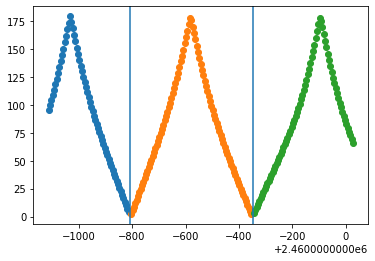

In [213]:

# Special Dedicace a Julien :-)

# How to find oppositions
p_conj = eph['Elong.'].isin( eph['Elong.'].values[argrelextrema(eph['Elong.'].values, np.less)[0]] )
nb_oppo = len(eph[p_conj])

# Graphically
fig, ax = plt.subplots()

# First part
cond = eph.Date < eph.loc[p_conj,'Date'].values[0]
ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'Elong.'] )

# All middle part until last
for ko in range(1,nb_oppo):
    cond = (eph.Date > eph.loc[p_conj,'Date'].values[ko-1]) & (eph.Date < eph.loc[p_conj,'Date'].values[ko])
    ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'Elong.'] )

# Last opposition
cond = eph.Date > eph.loc[p_conj,'Date'].values[-1]
ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'Elong.'] )

for ko in range(nb_oppo):
    ax.axvline( eph.loc[p_conj,'Date'].values[ko] )
